In [325]:
from deploy.preprocess import decode_image
from deploy.infer import Detector, DetectorPicoDet, PredictConfig, print_arguments, get_test_images, bench_log
from deploy.keypoint_infer import KeyPointDetector, PredictConfig_KeyPoint
from deploy.visualize import visualize_pose
from deploy.benchmark_utils import PaddleInferBenchmark
from deploy.utils import get_current_memory_mb
from deploy.keypoint_postprocess import translate_to_ori_images
from pathlib import Path
from typing import Literal, List, Dict, TypedDict, Any, cast, Tuple, Optional
from pydantic import BaseModel
from numpy.typing import NDArray
import numpy as np
import cv2
import cv2 as cv
from cv2.typing import MatLike
from loguru import logger
import matplotlib.pyplot as plt
import matplotlib
from typeguard import check_type, typechecked
from jaxtyping import Float, Int


class DetectionResult(TypedDict):
    # images
    # box count
    boxes_num: Int[np.ndarray, "1"]
    # images
    # bounding box (not sure about the meaning of the numbers, why 6?)
    boxes: Float[np.ndarray, "... 6"]


# COCO keypoint Description:
#     0: "Nose",
#     1: "Left Eye",
#     2: "Right Eye",
#     3: "Left Ear",
#     4: "Right Ear",
#     5: "Left Shoulder,
#     6: "Right Shoulder",
#     7: "Left Elbow",
#     8: "Right Elbow",
#     9: "Left Wrist",
#     10: "Right Wrist",
#     11: "Left Hip",
#     12: "Right Hip",
#     13: "Left Knee",
#     14: "Right Knee",
#     15: "Left Ankle",
#     16: "Right Ankle"
KeyPoints = Float[np.ndarray, "... 17 3"]
BoundingBoxes = Float[np.ndarray, "... 4"]


class KeyPointDetectionResult(TypedDict):
    # images
    # key points (17)
    # x y confidence
    keypoints: KeyPoints
    # images
    # bounding boxes
    #  - x_min y_min x_max y_max
    bboxes: BoundingBoxes
    # images
    # key point scores
    # (not sure why not a flat array, maybe it's consistent with other features)
    scores: Float[np.ndarray, "... 1"]


class ImageInfo(TypedDict):
    # im.shape[:2]
    shape: Int[np.ndarray, "2"]
    # scale_factor for each axis
    scale_factor: Float[np.ndarray, "2"]


class KeyPointAngleFeaturesDict(TypedDict):
    left_arm_angle: float
    right_arm_angle: float
    left_leg_angle: float
    right_leg_angle: float
    head_angle: float
    body_slope_angle: float
    hip_slope_angle: float


# 7 key points angles
# in order of
#  - left arm
#  - right arm
#  - left leg
#  - right leg
#  - head
#  - body slope
#  - hip slope
KeyPointsAngleFeatures = Float[np.ndarray, "... 7"]

DeviceType = Literal["GPU", "CPU", "XPU"]
# paddle/trt_fp32/trt_fp16/trt_int8
RunMode = Literal["paddle", "trt_fp32", "trt_fp16", "trt_int8"]

MODELS_DIR = Path("models")
DETECTION_MODEL_DIR = MODELS_DIR / "picodet_v2_s_320_pedestrian"
KEYPOINT_MODEL_DIR = MODELS_DIR / "tinypose_256x192"
DEVICE: DeviceType = "GPU"
RUN_MODE: RunMode = "paddle"
USE_DARK_POSE = True


In [326]:
class DetectionParams(BaseModel):
    detection_thres:float
    key_points_visual_thresh:float

In [327]:
def predict_with_given_det(
        image: MatLike,
        det_res: DetectionResult,
        keypoint_detector: KeyPointDetector,
        run_benchmark: bool = False) -> KeyPointDetectionResult:
    keypoint_res: KeyPointDetectionResult = {
        "bboxes": np.empty((0, 4), dtype=np.float32),
        "keypoints": np.empty((0, 17, 3), dtype=np.float32),
        "scores": np.empty((0, 1), dtype=np.float32),
    }

    rec_images, records, det_rects = keypoint_detector.get_person_from_rect(
        image, det_res)

    if len(det_rects) == 0:
        return keypoint_res

    keypoint_vector = []
    score_vector = []

    rect_vector = det_rects
    keypoint_results = keypoint_detector.predict_image(rec_images,
                                                       run_benchmark,
                                                       repeats=10,
                                                       visual=False)
    keypoint_vector, score_vector = translate_to_ori_images(
        keypoint_results, np.array(records))
    keypoint_res["keypoints"] = np.array(keypoint_vector)
    keypoint_res['bboxes'] = np.array(rect_vector)
    keypoint_res['scores'] = np.array(score_vector)
    return keypoint_res

In [328]:
# if the arch is not PicoDet
detector = Detector(DETECTION_MODEL_DIR, device=DEVICE, run_mode=RUN_MODE)
kp_detector = KeyPointDetector(KEYPOINT_MODEL_DIR,
                               device=DEVICE,
                               run_mode=RUN_MODE,
                               use_dark=USE_DARK_POSE)


# detector needs RGB with dtype uint8 (8UC3)
def preprocess(frame: MatLike) -> Tuple[MatLike, ImageInfo]:
    assert frame.dtype == np.uint8, "Image pixel type should be uint8_t"
    assert frame.shape[2] == 3, "The image does not have 3 channels"
    im = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    info: ImageInfo = {
        "shape": np.array(im.shape[:2], dtype=np.float32),
        "scale_factor": np.array([1., 1.], dtype=np.float32)
    }
    return im, info


def predict(
    image: MatLike, detector: Detector, topdown_kp_detector: KeyPointDetector,
    params: DetectionParams
) -> Tuple[DetectionResult, KeyPointDetectionResult]:
    detections = detector.predict_image([image], visual=False)
    det_res = detector.filter_box(detections, params.detection_thres)
    det_res = cast(DetectionResult, det_res)
    kp_res = predict_with_given_det(image, det_res, topdown_kp_detector)
    kp_res = cast(KeyPointDetectionResult, kp_res)
    return det_res, kp_res

-----------  Model Configuration -----------
Model Arch: GFL
Transform Order: 
--transform op: Resize
--transform op: Permute
--------------------------------------------
-----------  Model Configuration -----------
Model Arch: HRNet
Transform Order: 
--transform op: TopDownEvalAffine
--transform op: NormalizeImage
--transform op: Permute
--------------------------------------------


In [425]:
background = cv.imread("handsup.jpeg")
# background = cv.imread("test.jpeg")

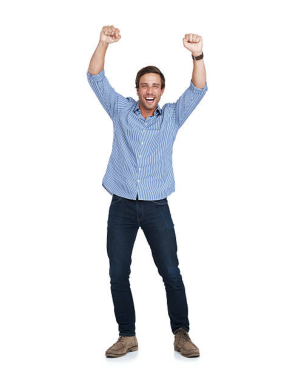

In [426]:
rgb, info = preprocess(background)
plt.axis("off")
plt.imshow(rgb)
plt.show()

In [427]:
params = DetectionParams(detection_thres=0.5, key_points_visual_thresh=0.5)
det, kp = predict(rgb, detector, kp_detector, params)
display(det)
display(kp)

Test iter 0


{'boxes': array([[  0.        ,   0.96633685, 121.04007   ,  24.500986  ,
         330.2018    , 582.07263   ]], dtype=float32),
 'boxes_num': array([1])}

{'bboxes': array([[121,  24, 330, 582]]),
 'keypoints': array([[[230.6158    , 138.78204   ,   0.92810494],
         [239.2899    , 132.22827   ,   0.8688111 ],
         [222.53062   , 130.41362   ,   0.9181784 ],
         [251.92041   , 139.06496   ,   0.8686944 ],
         [208.92969   , 135.29393   ,   0.8377443 ],
         [269.26913   , 179.64299   ,   0.9325929 ],
         [181.84612   , 167.06033   ,   0.90104854],
         [309.23108   , 132.45116   ,   1.0449015 ],
         [141.46378   , 112.069695  ,   0.9371367 ],
         [310.05377   ,  77.49654   ,   1.069669  ],
         [154.25429   ,  59.68364   ,   0.9535064 ],
         [240.08746   , 336.11127   ,   0.9147965 ],
         [186.00035   , 335.69974   ,   0.8751063 ],
         [265.87408   , 440.17853   ,   0.9248742 ],
         [180.75307   , 443.40204   ,   0.9440318 ],
         [281.7332    , 530.22516   ,   0.9575333 ],
         [193.74458   , 535.3749    ,   0.954714  ]]], dtype=float32),
 'scores': array([[0.93126

In [428]:
import math


def visualize_keypoints(kp_result: KeyPoints,
                        background: MatLike,
                        visual_thresh: float = 0.6,
                        kp_stick_width: int = 2,
                        kp_circle_radius: int = 2,
                        color_set: Optional[Any] = None) -> MatLike:
    skeletons = kp_result
    kpt_nums = 17
    if len(skeletons) > 0:
        kpt_nums = skeletons.shape[1]
    if kpt_nums == 17:  #plot coco keypoint
        EDGES = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 7),
                 (6, 8), (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14),
                 (13, 15), (14, 16), (11, 12)]
    else:  #plot mpii keypoint
        EDGES = [(0, 1), (1, 2), (3, 4), (4, 5), (2, 6),
                 (3, 6), (6, 7), (7, 8), (8, 9), (10, 11), (11, 12), (13, 14),
                 (14, 15), (8, 12), (8, 13)]
    NUM_EDGES = len(EDGES)

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
            [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
            [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    cmap = matplotlib.colormaps.get_cmap('hsv')

    canvas = background.copy()

    for i in range(kpt_nums):
        for j in range(len(skeletons)):
            if skeletons[j][i, 2] < visual_thresh:
                continue
            if True:
                color = colors[i] if color_set is None else colors[
                    color_set[j] % len(colors)]
            else:
                color = get_color(ids[j])

            cv2.circle(canvas,
                       tuple(skeletons[j][i, 0:2].astype('int32')),
                       kp_circle_radius,
                       color,
                       thickness=-1)

    for i in range(NUM_EDGES):
        for j in range(len(skeletons)):
            edge = EDGES[i]
            if skeletons[j][edge[0], 2] < visual_thresh or skeletons[j][
                    edge[1], 2] < visual_thresh:
                continue

            cur_canvas = canvas.copy()
            X = [skeletons[j][edge[0], 1], skeletons[j][edge[1], 1]]
            Y = [skeletons[j][edge[0], 0], skeletons[j][edge[1], 0]]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1])**2 + (Y[0] - Y[1])**2)**0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY), int(mX)),
                                       (int(length / 2), kp_stick_width),
                                       int(angle), 0, 360, 1)
            if True:
                color = colors[i] if color_set is None else colors[
                    color_set[j] % len(colors)]
            else:
                color = get_color(ids[j])
            cv2.fillConvexPoly(cur_canvas, polygon, color)  # type: ignore
            canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    return canvas


def visualize_bounding_boxes(bboxes: BoundingBoxes,
                             background: MatLike,
                             bb_thickness: int = 1,
                             color_set: Optional[Any] = None) -> MatLike:
    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
            [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
            [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
    cmap = matplotlib.colormaps.get_cmap('hsv')
    canvas = background.copy()
    for j, rect in enumerate(bboxes):
        xmin, ymin, xmax, ymax = rect
        color = colors[0] if color_set is None else colors[color_set[j] %
                                                           len(colors)]
        cv2.rectangle(canvas, (xmin, ymin), (xmax, ymax), color, bb_thickness)
    return canvas


def visualize(
        frame: MatLike,
        results: KeyPointDetectionResult,
        visual_thresh: float = 0.6,
        bb_thickness: int = 1,
        kp_stick_width: int = 2,
        kp_circle_radius: int = 2,
        draw_background: bool = True,
        background_color: Tuple[int, int, int] = (255, 255, 255),
) -> MatLike:
    """visualize the keypoint detection results

    Args:
        frame (MatLike): input image
        results (KeyPointDetectionResult): keypoint detection results
        visual_thresh (float, optional): threshold for visualization. Defaults to 0.6.
        bb_thickness (int, optional): bounding box thickness. Defaults to 1.
        kp_stick_width (int, optional): keypoint stick width. Defaults to 2.
        draw_background (bool, optional): whether draw on a the image as background. Defaults to True.
        background_color (Tuple[int, int, int], optional): if not draw on a the image as background, the color of the background. Defaults to (255, 255, 255).

    Returns:
        MatLike
    """
    canvas = frame.copy() if draw_background else np.zeros_like(frame)
    if not draw_background:
        canvas[:] = background_color
    with_bb = visualize_bounding_boxes(results["bboxes"], canvas, bb_thickness)
    result = visualize_keypoints(results["keypoints"],
                                 with_bb,
                                 visual_thresh=visual_thresh,
                                 kp_stick_width=kp_stick_width,
                                 kp_circle_radius=kp_circle_radius)
    return result


In [429]:
img_w = background.shape[1]
img_h = background.shape[0]
stick_width = (img_w + img_h) // 200
circle_radius = stick_width * 2
bb_thickness = stick_width
res_img = visualize(rgb, kp, params.key_points_visual_thresh, bb_thickness=bb_thickness, kp_stick_width=stick_width, kp_circle_radius=circle_radius, draw_background=True)

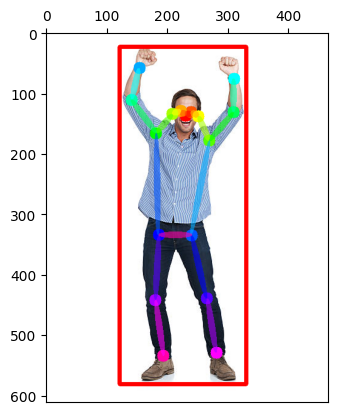

In [440]:
plt.imshow(res_img)
plt.gca().xaxis.tick_top()
plt.show()

In [431]:
# A = Int[np.ndarray, "1"]
# B = Float[np.ndarray, "... 6"]
# check_type("A", det["boxes_num"], A)
# check_type("B", det["boxes"], B)
display(det["boxes_num"].shape)
display(det["boxes"].shape)
display(np.array(kp["keypoints"]).shape)
display(np.array(kp["bboxes"]).shape)

(1,)

(1, 6)

(1, 17, 3)

(1, 4)

In [432]:
def normalize_keypoint(kps: KeyPoints, bboxes: BoundingBoxes) -> KeyPoints:
    # https://donologue.tistory.com/398
    # https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.7/configs/keypoint/tiny_pose
    r_kps = np.empty_like(kps)
    assert len(kps) == len(
        bboxes
    ), "keypoints and bounding boxes should have the same length (since they are one-to-one pair)"
    for i, k, b in zip(range(len(kps)), kps, bboxes):
        i: int
        KP_Type = Float[np.ndarray, "17 3"]
        BB_Type = Int[np.ndarray, "4"]
        check_type("k", k, KP_Type)
        # assert b.shape == (4,), "bounding box should have 4 elements"
        check_type("b", b, BB_Type)
        k: Float[np.ndarray, "17 3"]
        b: Float[np.ndarray, "4"]
        # x_min y_min x_max y_max
        k = k.copy()

        w = b[2] - b[0]
        h = b[3] - b[1]
        k[:, 0] = (k[:, 0] - b[0])
        k[:, 1] = (k[:, 1] - b[1])

        l_shoulder_hip_height = np.linalg.norm(k[5] - k[11])
        r_shoulder_hip_height = np.linalg.norm(k[6] - k[12])
        shoulder_hip_height = np.mean(
            [l_shoulder_hip_height, r_shoulder_hip_height])

        l_arm_length = np.linalg.norm(k[5] - k[7]) + np.linalg.norm(k[7] -
                                                                    k[9])
        r_arm_length = np.linalg.norm(k[6] - k[8]) + np.linalg.norm(k[8] -
                                                                    k[10])
        arm_length = np.mean([l_arm_length, r_arm_length])

        l_leg_length = np.linalg.norm(k[12] - k[14]) + np.linalg.norm(k[14] -
                                                                      k[16])
        r_leg_length = np.linalg.norm(k[11] - k[13]) + np.linalg.norm(k[13] -
                                                                      k[15])
        leg_length = np.mean([l_leg_length, r_leg_length])

        # make sure arm length + leg length + shoulder_hip_height
        # can fit the height of bounding box (which should be 0-1)
        bounding_box_i_scale_factor = h if h > w else w
        length_i_scale_factor = shoulder_hip_height + arm_length + leg_length
        i_scale_factor = max(bounding_box_i_scale_factor,
                             length_i_scale_factor)
        scale_factor = 1 / i_scale_factor
        k[:, 0] = k[:, 0] * scale_factor
        k[:, 1] = k[:, 1] * scale_factor
        # move the center of skeleton to [0.5, 0.5]
        c_s = np.mean(k[:, :2], axis=0)

        skeleton_y_max = np.max(k[:, 1])
        skeleton_y_min = np.min(k[:, 1])
        skeleton_height = skeleton_y_max - skeleton_y_min
        skeleton_center_y_ratio = c_s[1] / skeleton_height

        # calculate the path from the center now to the expected point
        # then move the center to the expected point
        expected_point = np.array([0.5, skeleton_center_y_ratio])
        path_to_expected_point = expected_point - c_s
        k[:, :2] = k[:, :2] + path_to_expected_point

        r_kps[i] = k

    return r_kps


In [433]:
new_kps = normalize_keypoint(np.array(kp["keypoints"]), np.array(kp["bboxes"]))
display(new_kps)

array([[[0.50557363, 0.2716819 , 0.92810494],
        [0.52111864, 0.25993678, 0.8688111 ],
        [0.49108404, 0.25668472, 0.9181784 ],
        [0.5437539 , 0.2721889 , 0.8686944 ],
        [0.4667096 , 0.2654308 , 0.8377443 ],
        [0.57484484, 0.3449094 , 0.9325929 ],
        [0.41817275, 0.32235983, 0.90104854],
        [0.64646125, 0.26033622, 1.0449015 ],
        [0.34580296, 0.2238103 , 0.9371367 ],
        [0.64793557, 0.16185123, 1.069669  ],
        [0.36872503, 0.12992847, 0.9535064 ],
        [0.52254796, 0.62531847, 0.9147965 ],
        [0.42561764, 0.624581  , 0.8751063 ],
        [0.5687605 , 0.81181896, 0.9248742 ],
        [0.41621387, 0.81759584, 0.9440318 ],
        [0.5971818 , 0.9731929 , 0.9575333 ],
        [0.43949616, 0.98242176, 0.954714  ]]], dtype=float32)

(400, 400, 3)

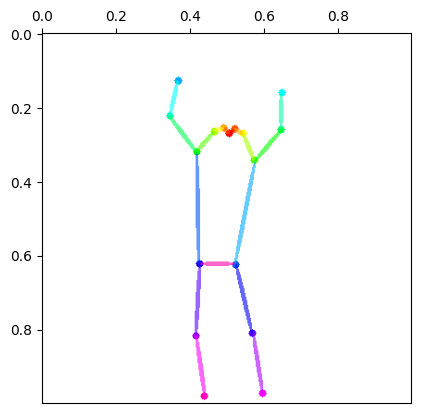

In [439]:
VISUALIZE_SCALE_FACTOR = 400
background = np.zeros((VISUALIZE_SCALE_FACTOR, VISUALIZE_SCALE_FACTOR, 3),
                      dtype=np.uint8)
scaled_new_kps = new_kps * VISUALIZE_SCALE_FACTOR
background.fill(255)
v = visualize_keypoints(scaled_new_kps,
                        background,
                        visual_thresh=0.5,
                        kp_stick_width=2,
                        kp_circle_radius=4)
display(v.shape)
plt.xticks(np.linspace(0, VISUALIZE_SCALE_FACTOR, num=6),
           np.round(np.linspace(0, 1, num=6), 2)) # type: ignore
plt.yticks(np.linspace(0, VISUALIZE_SCALE_FACTOR, num=6),
           np.round(np.linspace(0, 1, num=6), 2)) # type: ignore
plt.gca().xaxis.tick_top()
plt.imshow(v)

In [435]:
NDPoint = Float[np.ndarray, "2 "]

@typechecked
def calculate_angle(A: NDPoint, B: NDPoint, C: NDPoint) -> float:
    """
    B is the vertex of the angle. A and C are the other two points.
    """
    BA = A - B
    BC = C - B
    cosine_angle = np.dot(BA, BC) / (np.linalg.norm(BA) * np.linalg.norm(BC))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    assert 0 <= angle <= np.pi, f"angle: {angle} is not in [0, π] range"
    return angle

In [441]:
def keypoint_angles(norm_kp: KeyPoints) -> KeyPointsAngleFeatures:
    res = np.empty((len(norm_kp), 7), dtype=np.float32)
    pts = norm_kp[:, :, :2]
    assert pts.max() <= 1 and pts.min() >= 0, "normalized keypoints should be in [0, 1] range"
    for i, k in zip(range(len(pts)), pts):
        check_type("k", k, Float[np.ndarray, "17 2"])
        # 左臂弯曲角度（5-7-9）
        left_arm_angle = calculate_angle(k[5], k[7], k[9])

        # 右臂弯曲角度（6-8-10）
        right_arm_angle = calculate_angle(k[6], k[8], k[10])

        # 左腿弯曲角度（11-13-15）
        left_leg_angle = calculate_angle(k[11], k[13], k[15])

        # 右腿弯曲角度（12-14-16）
        right_leg_angle = calculate_angle(k[12], k[14], k[16])

        # 头部倾斜角度（0-脖子中点-脖子中点+垂直向上），脖子中点假定为左肩与右肩的中点
        neck = np.mean([k[5], k[6]], axis=0)
        head_angle = calculate_angle(k[0], neck, neck + np.array([0, 1]))

        # 身体倾斜角度（5-6-水平向右），假定水平向右为x轴正方向
        body_slope_angle = calculate_angle(k[6], k[5], k[5] + np.array([1, 0]))

        # 髋部倾斜角度（11-12-水平向右），同样假定水平向右为x轴正方向
        hip_slope_angle = calculate_angle(k[12], k[11],
                                          k[11] + np.array([1, 0]))

        res[i] = np.array([
            left_arm_angle, right_arm_angle, left_leg_angle, right_leg_angle,
            head_angle, body_slope_angle, hip_slope_angle
        ])
    return res

In [442]:
angles = keypoint_angles(new_kps)
display(angles)

array([[2.4539294, 2.26871  , 3.0730293, 2.952585 , 2.9963048, 2.9986455,
        3.13399  ]], dtype=float32)